In [502]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

In [503]:
# QuickView
class QuickView:
    def __init__(self, df, target=None, max_unique=10):
        # Сохраняем входные параметры (поведение исходных функций не меняем)
        self.df = df
        self.target = target
        self.max_unique = max_unique

    def quick_overview(self):
        # --- Общий обзор: внешний вид, размер, типы, пропуски, дубликаты, баланс таргета ---
        df = self.df
        target = self.target
        print("Внешний вид:", df.head().T)
        print("Размер:", df.shape)
        print("\nТипы данных:\n", df.dtypes)
        print("\nПропуски (шт):\n", df.isnull().sum())
        dup = df.duplicated().sum()
        print(f"\nДубликатов: {dup} ({dup/len(df)*100:.2f}%)")
        if target and target in df.columns:
            print("\nБаланс таргета:")
            print(df[target].value_counts(normalize=True))

    def quick_details(self):
        # --- Детали: describe, min/max, частоты категориальных/низко-кардинальных, уникальные значения ---
        df = self.df
        target = self.target
        max_unique = self.max_unique

        print("\n--- Статистика числовых признаков ---")
        print(df.describe())

        print("\n--- Min/Max по числовым ---")
        desc = df.describe()
        print(desc.loc[['min', 'max']] if 'min' in desc.index else desc[['min', 'max']])

        print("\n--- Частоты категориальных ---")
        for col in df.columns:
            if df[col].dtype == 'object' or df[col].nunique() <= max_unique:
                # Частоты значений (включая NaN)
                print(f"\nЧастоты в '{col}':")
                print(df[col].value_counts(dropna=False))

        if target and target in df.columns:
            # Корреляции числовых признаков с таргетом (ожидается числовой таргет)
            print("\n--- Корреляции с таргетом ---")
            print(df.corr(numeric_only=True)[target].sort_values(ascending=False))

    def quick_plots(self):
        # --- Гистограммы числовых столбцов ---
        axes = self.df.hist(figsize=(12, 8), bins=50)
        fig = axes.ravel()[0].figure
        fig.tight_layout()
        fig.subplots_adjust(hspace=0.5, wspace=0.3)
        plt.show()


    def quick_boxplots(self, cols=None, ncols=3):
        y = self.target
        if not y or y not in self.df.columns: print("Укажи корректный target"); return
        base = self.df.drop(columns=['id','Unnamed: 0','Unnamed:0'], errors='ignore')
        cols = cols or [c for c in base.select_dtypes(include="number").columns if c != y]
        nrows = (len(cols) + ncols - 1) // ncols
        fig, axes = plt.subplots(nrows, ncols, figsize=(3.2*ncols, 2.4*nrows), squeeze=False)
        for ax, c in zip(axes.ravel(), cols):
            base.boxplot(column=c, by=y, ax=ax); ax.set_title(c); ax.set_xlabel(y)
        for ax in axes.ravel()[len(cols):]: ax.set_visible(False)
        plt.suptitle(""); fig.tight_layout(); plt.show()

    def report(self):
        # --- Полный отчёт ---
        self.quick_overview()
        self.quick_details()
        self.quick_plots()
        self.quick_boxplots()

In [504]:
# EDAAnalyzer
class EDAAnalyzer:
    def __init__(self, df, target_col=None):
        self.df = df.copy()
        self.target_col = target_col
        # Удаляем служебные столбцы, если есть
        drop_cols = [col for col in self.df.columns
                     if col.lower() in ['unnamed: 0', 'unnamed:0', 'id']]
        self.df.drop(columns=drop_cols, errors='ignore', inplace=True)
        # Исправляем некорректные категории (например, Gender)
        if 'Gender' in self.df.columns:
            self.df['Gender'] = self.df['Gender'].replace({'Male': '1.0', 'Female': '0.0'})
        # Определяем числовые и категориальные столбцы
        self.numeric_cols = []
        self.cat_cols = []
        for col in self.df.columns:
            if col == self.target_col:
                continue
            if self.df[col].dtype == object or self.df[col].nunique() <= 10:
                self.cat_cols.append(col)
            else:
                self.numeric_cols.append(col)
    def overview(self):
        print(f"Размер датасета: {self.df.shape}")
        print("Колонки:", list(self.df.columns))
        if self.target_col:
            print(f"Распределение таргета:\n{self.df[self.target_col].value_counts()}")
    def missing_values(self):
        n0 = len(self.df)
        # считаем пустые строки и текстовые маркеры как пропуски
        self.df.replace(r'^\s*$', pd.NA, regex=True, inplace=True)
        self.df.replace({'na': pd.NA, 'n/a': pd.NA, 'none': pd.NA,
                         'null': pd.NA, 'NaN': pd.NA, 'nan': pd.NA}, inplace=True)

        miss = self.df.isna().sum()
        rm = int(self.df.isna().any(axis=1).sum())
        if rm:
            self.df.dropna(axis=0, how='any', inplace=True)
            print(f"Удалено строк с пропусками: {rm} из {n0} ({rm/n0*100:.2f}%).")
            print("Пропуски по столбцам (до удаления):")
            print(miss[miss > 0].sort_values(ascending=False))
        else:
            print("Нет пропусков — ничего не удалено.")
    def feature_stats(self):
        if self.numeric_cols:
            print("\nСаммари:")
            print(self.df[self.numeric_cols].describe().T)
        if self.cat_cols:
            print("\nЧастоты категориальных признаков:")
            for col in self.cat_cols:
                counts = self.df[col].value_counts(dropna=False)
                print(f"{col}: {dict(counts)})")
    def target_analysis(self):
        if not self.target_col or self.target_col not in self.df.columns:
            return
        print(f"\nТаргет '{self.target_col}' анализ:")
        # Если таргет бинарный, покажем долю положительного класса
        if self.df[self.target_col].nunique() == 2:
            pos_rate = self.df[self.target_col].mean()
            print(f"Доля положительного класса: {pos_rate:.3f}")
        # Для категорий: частота положительного класса внутри каждой категории
        for col in self.cat_cols:
            ct = pd.crosstab(self.df[col], self.df[self.target_col], normalize='index')
            print(f"\n{col} vs {self.target_col}:")
            print(ct)


    def cast_dtypes(self):
        y = self.target_col
        for c in self.df.columns:
            if c == y:
                continue
            s = self.df[c]; k = s.nunique(dropna=True)

                # бинарные → boolean (без депрекейта в replace)
            if k == 2:
                u = s.astype('string').str.strip().str.lower()             # ← ключ
                t = pd.to_numeric(u.replace({'true':'1','false':'0'}), errors='coerce')
                if set(pd.unique(t.dropna())) <= {0,1}:
                    self.df[c] = t.astype('boolean'); continue
                # иначе упадём в категорию ниже

            # 2) Числовые целочисленные по факту → Int8
            if pd.api.types.is_numeric_dtype(s) and s.dropna().eq(s.dropna().astype(int)).all():
                self.df[c] = pd.to_numeric(s, errors='coerce').astype('Int8'); continue

            # 3) Низкая кардинальность → category (уровни = только наблюдаемые)
            if k <= 10:
                vals = pd.unique(s.dropna())
                self.df[c] = pd.Categorical(s, categories=vals, ordered=False); continue

            # 4) Остальное → float
            self.df[c] = pd.to_numeric(s, errors='coerce').astype('float64')

        # Финальная зачистка пустых уровней во всех категориальных
        for c in self.df.select_dtypes('category'):
            self.df[c] = self.df[c].cat.remove_unused_categories()

        self.numeric_cols = [c for c in self.df.select_dtypes('number').columns if c != y]
        self.cat_cols     = [c for c in self.df.select_dtypes('category').columns if c != y]



    def report(self):
        """Выводит полный отчет EDA."""
        self.overview()
        print("-"*50)
        self.cast_dtypes()
        print("-"*50)
        self.missing_values()
        print("-"*50)
        self.feature_stats()
        print("-"*50)
        if self.target_col:
            print("-"*50)
            self.target_analysis()
        print("-"*50)
        print(self.df.head().T)
        print("-"*50)
        print(self.df.dtypes)
        print("-"*50)

In [505]:
# === Настройки путей ===
DATA_DIR = Path.cwd().parent / "data"

TRAIN_PATH = DATA_DIR / "heart_train.csv"
TEST_PATH  = DATA_DIR / "heart_test.csv"
TARGET = "Heart Attack Risk (Binary)"

# === Загрузка данных ===
train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)

Внешний вид:                                         0         1         2         3  \
Unnamed: 0                              0         1         2         3   
Age                              0.359551  0.202247  0.606742  0.730337   
Cholesterol                      0.732143     0.325  0.860714  0.007143   
Heart rate                       0.074244  0.047663  0.055912  0.053162   
Diabetes                              1.0       1.0       1.0       0.0   
Family History                        1.0       1.0       0.0       0.0   
Smoking                               1.0       0.0       1.0       1.0   
Obesity                               1.0       0.0       1.0       0.0   
Alcohol Consumption                   1.0       1.0       1.0       1.0   
Exercise Hours Per Week          0.535505   0.06869  0.944001  0.697023   
Diet                                    1         2         2         0   
Previous Heart Problems               1.0       1.0       1.0       0.0   
Medication U

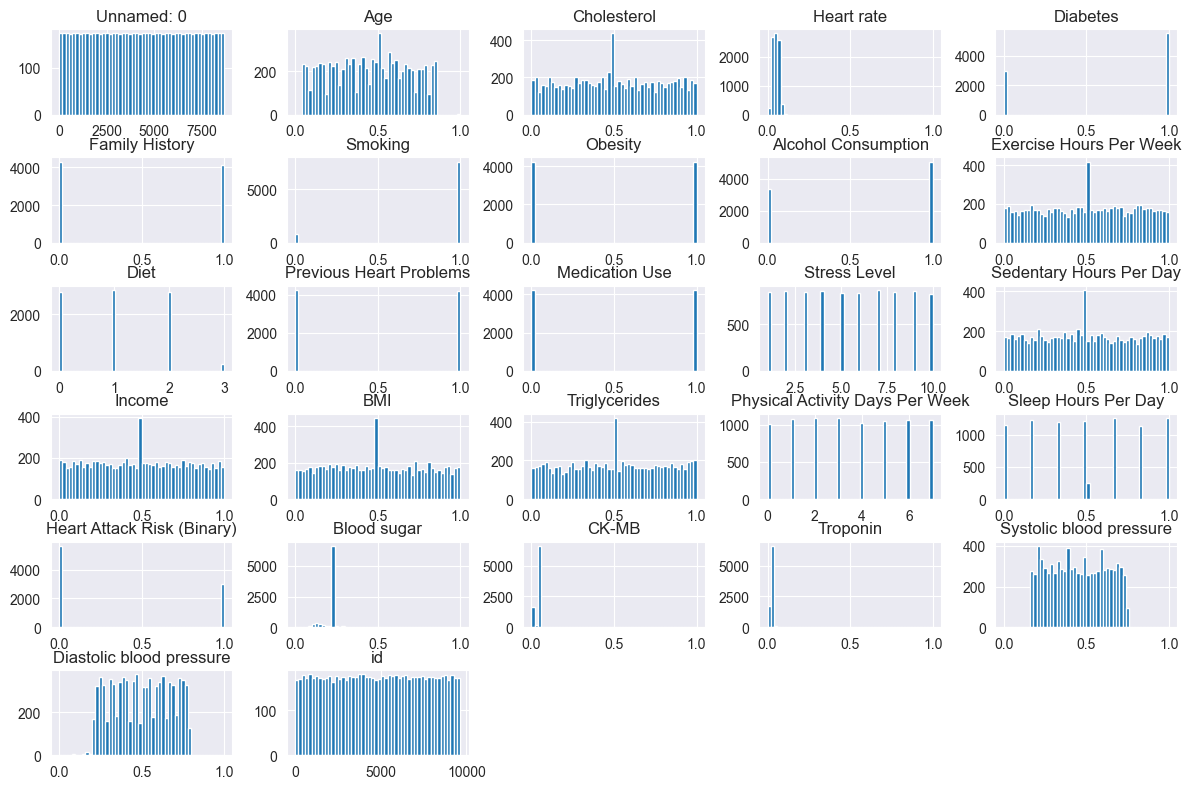

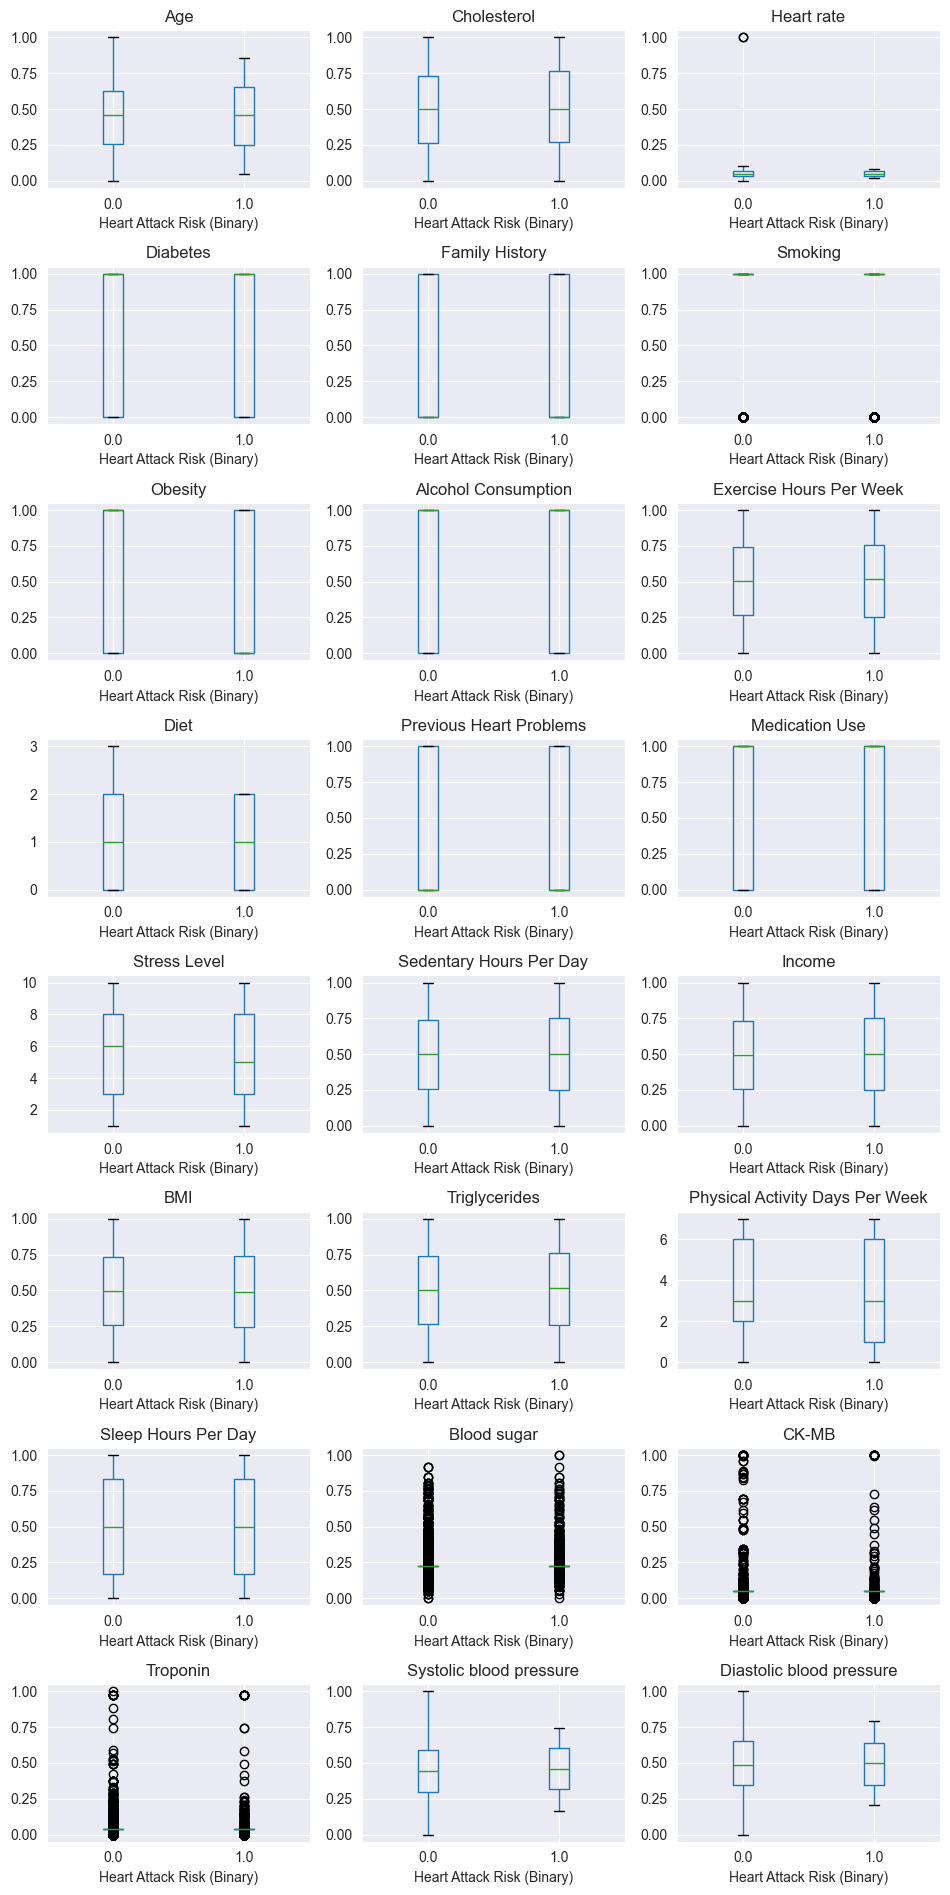

In [506]:
# === Быстрый обзор train ===
preEDA = QuickView(train_df, target="Heart Attack Risk (Binary)").report()


Внешний вид:                                         0         1         2         3  \
Unnamed: 0                              0         1         2         3   
Age                              0.494382  0.224719  0.629213  0.460674   
Cholesterol                      0.264286  0.953571  0.092857  0.567857   
Heart rate                       0.062328  0.082493  0.064161  0.055912   
Diabetes                              0.0       1.0       0.0       1.0   
Family History                        1.0       0.0       1.0       1.0   
Smoking                               1.0       0.0       1.0       1.0   
Obesity                               1.0       1.0       1.0       1.0   
Alcohol Consumption                   1.0       0.0       0.0       1.0   
Exercise Hours Per Week          0.361618  0.996483  0.995561  0.437277   
Diet                                    2         2         0         0   
Previous Heart Problems               0.0       1.0       0.0       0.0   
Medication U

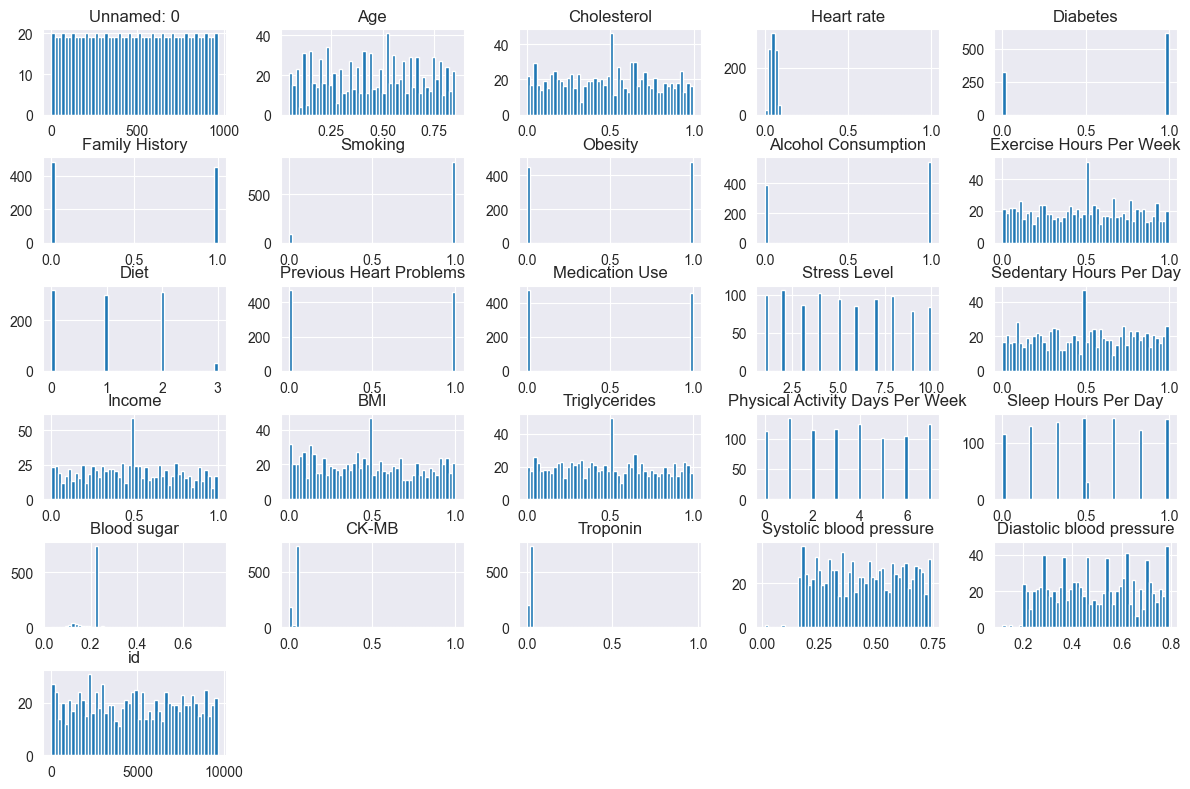

Укажи корректный target


In [507]:
# === Быстрый обзор test (без таргета) ===
QuickView(test_df, target="Heart Attack Risk (Binary)").report()

In [508]:
# EDA анализ
e = EDAAnalyzer(train_df, target_col="Heart Attack Risk (Binary)")
e.report()

Размер датасета: (8685, 26)
Колонки: ['Age', 'Cholesterol', 'Heart rate', 'Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Exercise Hours Per Week', 'Diet', 'Previous Heart Problems', 'Medication Use', 'Stress Level', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides', 'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Heart Attack Risk (Binary)', 'Blood sugar', 'CK-MB', 'Troponin', 'Gender', 'Systolic blood pressure', 'Diastolic blood pressure']
Распределение таргета:
Heart Attack Risk (Binary)
0.0    5672
1.0    3013
Name: count, dtype: int64
--------------------------------------------------
--------------------------------------------------
Удалено строк с пропусками: 243 из 8685 (2.80%).
Пропуски по столбцам (до удаления):
Diabetes                           243
Family History                     243
Smoking                            243
Obesity                            243
Alcohol Consumption                243
Previous Heart Problems